# Imports

In [1]:
## Network Processing
import networkx as nx 
from barabasi_albert import barabasi_albert_graph

## Visualization 
from matplotlib import pyplot as plt
import seaborn as sns

## Matrix Processing
import numpy as np
import pandas as pd
import scipy as sp

## RF
from predict_params import GraphScorer, preprocess, get_rf_grid, ParamPredictor
from sklearn.metrics import accuracy_score, mean_absolute_error, recall_score, precision_score, mean_squared_error

## GNN 
import tensorflow as tf
import keras.backend as K
from keras.models import Input, Model, Sequential
from keras.losses import MeanSquaredError
from keras.layers import Dense, Activation, Dropout, Lambda
from keras.callbacks import History, EarlyStopping
from multi_graph_cnn_layer import MultiGraphCNN

## Data Processing
from sklearn.utils import shuffle

## Tool functions
from utils import *
from tqdm import tqdm

## Error metrics
from sklearn.metrics import mean_squared_error

## Experiment metrics
from graph_scoring import GraphScorer

## Seed the pseudorandom number generator
from random import randint,seed

# CONSTANTS

In [61]:
# Specify whether to use a symmetric norm for the adjacency matrix or not
SYM_NORM = True 

# set 2 for standard BA model, 3 for non-linear BA model
NB_BARABASI_PARAM = 3 

# Choose 'standard' for 2 params, 'standard', 'alpha noise' or 'non-linear' for 3 params
EXPERIMENT = "non-linear" 

## Seed random number generator
SEED = 0
seed(SEED)

# TOOL FUNCTIONS

### Data Generation

In [62]:
def generate_barabasi_adj_matrix(n, m, alpha,seed=None):
    """Generates a Barabasi Alert graph and returns an adjacency matrix with
     a node ordering defined by the networkx Graph library"""
    networkx_graph = barabasi_albert_graph(n, m, alpha,seed=seed)
    adj_matrix = nx.linalg.graphmatrix.adjacency_matrix(networkx_graph, nodelist=None, weight=None)
    return adj_matrix.todense()

In [63]:
def generate_BA_graphs_for_GNN(nb_graphs, n, train_size,NB_BARABASI_PARAM=2,exp_type = "standard",train=True):
    """Generates 'nb_graphs' Barabasi graphs. Each graph has the same number of nodes 'n', the first 
    parameter of the Barabasi-Albert model. The second parameter 'm' is randomly generated 
    in 1 <= m < n. The third parameter alpha is generated in 1/3 < alpha < 3.
    The function outputs the adjacency matrices, the feature matrices (identity matrices) 
    and the parameters n and m used in the data generation process"""
    
    # Each matrix generated during the graph generation process is vertically concatenated to the output
    adjacency_matrices = np.zeros((nb_graphs*n, n))
    feature_matrices = np.zeros((nb_graphs*n, n))
    parameter_vectors = np.zeros((nb_graphs, NB_BARABASI_PARAM))    
    
    for sample_graph_index in tqdm(range(nb_graphs)):
        
        if train:
            set_seed=sample_graph_index
        else:
            set_seed=sample_graph_index + train_size
            
        np.random.seed(set_seed)
        seed(set_seed)
        
        # Choose m randomly s.t 1 <= m < n
        m = randint(1, n-1)
        
        # Choose alpha according to experiment type
        if exp_type == "standard":
            alpha = 1
        elif exp_type == "alpha noise":
            alpha = np.random.normal(1,0.1)
        elif exp_type == "non-linear":
            alpha = np.random.uniform(1/3, 3)
        elif isinstance(exp_type, str):
            raise ValueError
        else:
            raise TypeError

        # Generate Barabasi Graph adjacency matrix
        adj_matrix = generate_barabasi_adj_matrix(n, m, alpha, seed=set_seed)

        # Update output matrices
        row_start_index = n * sample_graph_index
        
        adjacency_matrices[row_start_index: row_start_index + n, :] = adj_matrix
        feature_matrices[row_start_index: row_start_index + n, :] = np.eye(n)
        if NB_BARABASI_PARAM == 2:
            parameter_vectors[sample_graph_index, :] = [n, m]
        elif NB_BARABASI_PARAM == 3:
            parameter_vectors[sample_graph_index, :] = [n, m, alpha]
    
    return adjacency_matrices, feature_matrices, parameter_vectors

In [64]:
def load_our_data(adjacency_matrices_file_name, feature_matrices_file_name, parameter_vectors_file_name,seed):
    """Loads the data and prepares it for input into the GNN"""
    
    # Load and prepare the adjacency matrices
    A = pd.read_csv(adjacency_matrices_file_name, header=None)
    A = np.array(A)
    num_graph_nodes = A.shape[1]
    num_graphs = int(A.shape[0]/A.shape[1])

    A = np.split(A, num_graphs, axis=0)
    A = np.array(A)

    # Load and prepare the feature matrices
    X = pd.read_csv(feature_matrices_file_name, header=None)
    X = np.array(X)
    X = np.split(X, num_graphs, axis=0)
    X = np.array(X)

    # Load and prepare the parameter vectors
    Y = pd.read_csv(parameter_vectors_file_name, header=None)
    Y = np.array(Y)

    # Shuffle data before training
    A, X, Y = shuffle(A, X, Y,random_state=seed)
    
    return A, X, Y 

### Multi GNN

In [65]:

def train_multi_gnn_model(A, X, Y, NB_BARABASI_PARAM=3,num_filters = 2):
    """Build and train a multi GNN network. A is the matrix of adjacency matrices
    vertically concatenated. X is the matrix of feature matrices vertically concatenated. Y is the matrix 
    of parameter matrices vertically concatenated"""
    
    # build graph_conv_filters
    graph_conv_filters = preprocess_adj_tensor_by_filter(A, num_filters, SYM_NORM)

    # build model
    X_input = Input(shape=(X.shape[1], X.shape[2]))
    graph_conv_filters_input = Input(shape=(graph_conv_filters.shape[1], graph_conv_filters.shape[2]))

    output = MultiGraphCNN(200, num_filters, activation='elu')([X_input, graph_conv_filters_input])
    output = Dropout(0.2)(output)
    output = MultiGraphCNN(200, num_filters, activation='elu')([output, graph_conv_filters_input])
    output = Dropout(0.2)(output)
    
    # adding a node invariant layer to make sure output does not depends upon the node order in a graph.
    output = Lambda(lambda x: K.mean(x, axis=1))(output) 
    
    output = Dense(256, activation="relu")(output)
    output = Dense(128, activation="relu")(output)
    output = Dense(64, activation="relu")(output)
    output = Dense(32, activation="relu")(output)
    output = Dense(16, activation="relu")(output)
    output = Dense(4, activation="relu")(output)
    output = Dense(NB_BARABASI_PARAM)(output)

    nb_epochs = 1000
    batch_size = 64
    history = History()
    early_stopping = EarlyStopping(patience = 10)

    model = Model(inputs=[X_input, graph_conv_filters_input], outputs=output)
    
    model.compile(loss="mse", optimizer='adam')
    model.fit([X, graph_conv_filters], Y, batch_size=batch_size, validation_split=0.1, \
              epochs=nb_epochs, shuffle=True, verbose=1,callbacks=[history, early_stopping])
    
    return model, history.history

# Main

### Generate train & test data

In [66]:
# Instantiate parameters
train_size = 16000
test_size = 4000
NUMBER_OF_NODES = 50
NUM_FILTERS = 2

In [67]:
# Generate [train_size] graphs of [NUMBER_OF_NODES] nodes train data

adjacency_matrices_train, feature_matrices_train, parameter_vectors_train = \
    generate_BA_graphs_for_GNN(nb_graphs=train_size,
                               n=NUMBER_OF_NODES, 
                               train_size=train_size,
                               NB_BARABASI_PARAM=NB_BARABASI_PARAM,
                               exp_type = EXPERIMENT,
                               train=True)

100%|██████████| 16/16 [00:04<00:00,  4.00it/s]


In [68]:
# Generate [test_size] graphs of [NUMBER_OF_NODES] nodes test data
adjacency_matrices_test, feature_matrices_test, parameter_vectors_test = \
    generate_BA_graphs_for_GNN(nb_graphs=test_size,
                               n=NUMBER_OF_NODES, 
                               train_size=train_size,
                               NB_BARABASI_PARAM=NB_BARABASI_PARAM,
                               exp_type = EXPERIMENT,
                               train=False)

100%|██████████| 4/4 [00:00<00:00, 23.68it/s]


In [69]:
# Save data
# Since graph generation is expensive
np.savetxt('adjacency_matrices_train.csv', adjacency_matrices_train, delimiter=',')
np.savetxt('feature_matrices_train.csv', feature_matrices_train, delimiter=',')
np.savetxt('parameter_vectors_train.csv', parameter_vectors_train, delimiter=',')

np.savetxt('adjacency_matrices_test.csv', adjacency_matrices_test, delimiter=',')
np.savetxt('feature_matrices_test.csv', feature_matrices_test, delimiter=',')
np.savetxt('parameter_vectors_test.csv', parameter_vectors_test, delimiter=',')

In [70]:
# Load Train data
A_train, X_train, Y_train = load_our_data('adjacency_matrices_train.csv', 
                      'feature_matrices_train.csv', 
                      'parameter_vectors_train.csv',
                      seed=SEED)

# Load Test data
A_test, X_test, Y_test = load_our_data(
    "adjacency_matrices_test.csv",
    "feature_matrices_test.csv",
    "parameter_vectors_test.csv",
    seed=SEED,
)

## Random Forest 
Run a random forest model on extracted feature vectors, to predict the BA parameters n, m, alpha.

Feature Extraction: 

In [71]:
scorer = GraphScorer()

Xraw = []
for i in range(0, A_train.shape[0]):
    Xraw.append(nx.from_numpy_matrix(A_train[i]))
    
Xraw_tst = []
for i in range(0, A_test.shape[0]):
    Xraw_tst.append(nx.from_numpy_matrix(A_test[i]))

# preprocessing is time-consuming
X = preprocess(Xraw, scorer)
Xtst = preprocess(Xraw_tst, scorer)

Build & Train Model: 

In [72]:
model = get_rf_grid()
predictor = ParamPredictor(model=model, model_name='random_forest')
predictor.fit_model(X, Y_train)

Predict & Print Losses: 

In [73]:
Y_pred = predictor.predict_params(Xtst)

n_pred, m_pred, alpha_pred = Y_pred[:,0], Y_pred[:,1], Y_pred[:,2]
n_true,m_true,alpha_true = Y_test[:,0],Y_test[:,1],Y_test[:,2]

print("current model is ",predictor.model_name)
print("total mse is ", mean_squared_error(Y_pred, Y_test))
print("mse for n is ", mean_squared_error(n_pred, n_true))
print("mse for m is ", mean_squared_error(m_pred, m_true))
print("mse for alpha is ", mean_squared_error(alpha_pred, alpha_true))
print("mean absolute error for alpha is ", mean_absolute_error(alpha_pred, alpha_true))

current model is  random_forest
total mse is  7.189519201761442
mse for n is  0.0
mse for m is  21.390100000000004
mse for alpha is  0.17845760528432175
mean absolute error for alpha is  0.37966070899682314


In [74]:
# print pearson correlation 
# Remark: The correlation reported in the paper is a bit higher (0.8),
# because it was obtained by training on a larger dataset on the cluster. 

from scipy.stats import pearsonr

r, _ = pearsonr(alpha_true, alpha_pred)
print("pearson r correlation between true and predicted alpha is ",r)

pearson r correlation between true and predicted alpha is  0.9410117002830605


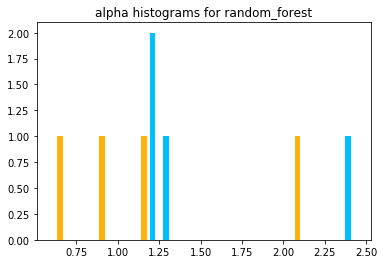

In [75]:
# plot histogram of true and predicted alpha values 
# we can see the histograms are very close
alphas = [alpha_pred, alpha_true]
    
plt.hist(alphas, 22, histtype='bar',color=['deepskyblue','xkcd:saffron'], label=['pred','true'])
plt.title("alpha histograms for "+predictor.model_name)
plt.savefig("alpha_hists_"+predictor.model_name + ".png")

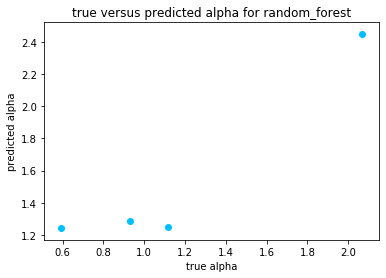

In [76]:
# plot true versus predicted alphas
# we see an almost linear correlation 
plt.scatter(x=Y_test[:, 2], y=Y_pred[:, 2],color="deepskyblue")
plt.ylabel("predicted alpha")
plt.xlabel("true alpha")
plt.title("true versus predicted alpha for "+predictor.model_name)
plt.savefig("predicted_alpha_"+predictor.model_name + ".png")

### Train GNN Encoder 

In [77]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)
seed(SEED)

# Train
model, hist = train_multi_gnn_model(A_train,
                                    X_train, 
                                    Y_train, 
                                    NB_BARABASI_PARAM=NB_BARABASI_PARAM, 
                                    num_filters=NUM_FILTERS)

Epoch 1/1000
1/1 [==============================] - 0s 132ms/step - loss: 999.2921 - val_loss: 1260.3855
Epoch 2/1000
1/1 [==============================] - 0s 32ms/step - loss: 999.2337 - val_loss: 1260.2866
Epoch 3/1000
1/1 [==============================] - 0s 33ms/step - loss: 999.1674 - val_loss: 1260.1842
Epoch 4/1000
1/1 [==============================] - 0s 31ms/step - loss: 999.0881 - val_loss: 1260.1782
Epoch 5/1000
1/1 [==============================] - 0s 38ms/step - loss: 999.1276 - val_loss: 1259.9077
Epoch 6/1000
1/1 [==============================] - 0s 42ms/step - loss: 998.8764 - val_loss: 1259.8190
Epoch 7/1000
1/1 [==============================] - 0s 38ms/step - loss: 998.8061 - val_loss: 1259.6416
Epoch 8/1000
1/1 [==============================] - 0s 27ms/step - loss: 998.6723 - val_loss: 1259.3909
Epoch 9/1000
1/1 [==============================] - 0s 33ms/step - loss: 998.4815 - val_loss: 1259.2015
Epoch 10/1000
1/1 [==============================] - 0s 26ms/st

1/1 [==============================] - 0s 25ms/step - loss: 903.7553 - val_loss: 1105.8007
Epoch 80/1000
1/1 [==============================] - 0s 27ms/step - loss: 902.1832 - val_loss: 1103.2682
Epoch 81/1000
1/1 [==============================] - 0s 37ms/step - loss: 900.6624 - val_loss: 1100.2727
Epoch 82/1000
1/1 [==============================] - 0s 27ms/step - loss: 898.9683 - val_loss: 1096.9670
Epoch 83/1000
1/1 [==============================] - 0s 28ms/step - loss: 897.2818 - val_loss: 1093.7297
Epoch 84/1000
1/1 [==============================] - 0s 28ms/step - loss: 895.7194 - val_loss: 1090.8240
Epoch 85/1000
1/1 [==============================] - 0s 28ms/step - loss: 894.1188 - val_loss: 1088.2734
Epoch 86/1000
1/1 [==============================] - 0s 28ms/step - loss: 892.3491 - val_loss: 1086.0841
Epoch 87/1000
1/1 [==============================] - 0s 28ms/step - loss: 890.7484 - val_loss: 1084.1133
Epoch 88/1000
1/1 [==============================] - 0s 27ms/step - l

In [78]:
def get_predictions(A, X):
    graph_conv_filters = preprocess_adj_tensor_by_filter(A, NUM_FILTERS, SYM_NORM)
    preds = model.predict([X, graph_conv_filters])
    if NB_BARABASI_PARAM == 2:
        # Round n and m to integers
        return np.rint(preds)
    elif NB_BARABASI_PARAM == 3:
        # Round n and m to integers
        Y_pred = np.zeros(preds.shape)
        Y_pred[:,:2] = np.rint(preds[:,:2])
        Y_pred[:,2] = preds[:,2]
        return Y_pred

def print_MSE(Y_true, Y_pred):
    if NB_BARABASI_PARAM == 2:
        print("n MSE: ", mean_squared_error(Y_true[:,0], Y_pred[:,0]))
        print("m MSE: ", mean_squared_error(Y_true[:,1], Y_pred[:,1]))
    elif NB_BARABASI_PARAM == 3:
        print("n MSE: ", mean_squared_error(Y_true[:,0], Y_pred[:,0]))
        print("m MSE: ", mean_squared_error(Y_true[:,1], Y_pred[:,1]))
        print("Alpha MSE: ", mean_squared_error(Y_true[:,2], Y_pred[:,2]))

### Test network

#### Results from Table I

In [79]:
# Print Test MSE

Y_pred = get_predictions(A_test, X_test)
print_MSE(Y_test, Y_pred)

n MSE:  86.0
m MSE:  276.25
Alpha MSE:  78.0021763940171


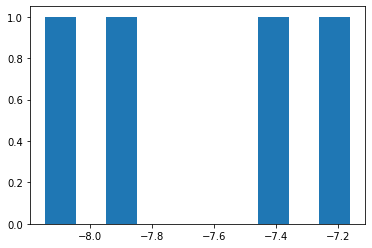

In [80]:
if NB_BARABASI_PARAM == 3:
    plt.hist(Y_pred[:,2])

### Plot learning curve

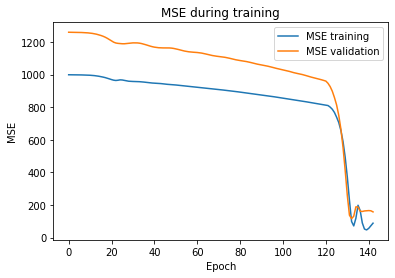

In [81]:
plt.plot(hist['loss'][5:], label='MSE training')
plt.plot(hist['val_loss'][5:], label='MSE validation')
plt.title('MSE during training')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

## Testing on Erdos-Reyni graphs

Goal: See whether our model predicts low values of alpha for ER graphs, since BA graphs with low alphas resemble ER

Run only if NB_BARABASI_PARAM = 3

In [82]:
NB_ER = 1000

In [83]:
def generate_er_adj_matrix(n, p):
    """Generates an Erdos Renyi graph and returns an adjacency matrix with
     a node ordering defined by the networkx Graph library"""
    
    networkx_graph = nx.erdos_renyi_graph(n, p)
    adj_matrix = nx.linalg.graphmatrix.adjacency_matrix(networkx_graph, nodelist=None, weight=None)
    
    return adj_matrix.todense()

def generate_multi_er_graphs(nb_graphs, n):
    """Generates 'nb_graphs' ER graphs. Each graph has the same number of nodes 'n', the first 
    parameter of the ER model. The second parameter 'p' is randomly generated 
    in 0 <= p < 0.5. The function outputs the adjacency matrices, the feature matrices (identity matrices) 
    and the parameters n and m used in the data generation process"""
    
    # Each matrix generated during the graph generation process is vertically concatenated to the output
    adjacency_matrices = np.zeros((nb_graphs*n, n))
    feature_matrices = np.zeros((nb_graphs*n, n))
    parameter_vectors = np.zeros((nb_graphs, 2))

    for sample_graph_index in range(nb_graphs):
        
        # Choose p randomly
        p = np.random.uniform(0, 0.5)

        # Generate Barabasi Graph adjacency matrix
        adj_matrix = generate_er_adj_matrix(n, p)

        # Update output matrices
        row_start_index = n * sample_graph_index
        
        adjacency_matrices[row_start_index: row_start_index + n, :] = adj_matrix
        feature_matrices[row_start_index: row_start_index + n, :] = np.eye(n)
        parameter_vectors[sample_graph_index, :] = [n, p]
    
    return adjacency_matrices, feature_matrices, parameter_vectors

In [84]:
adjacency_matrices_er, feature_matrices_er, parameter_vectors_er = generate_multi_er_graphs(nb_graphs = NB_ER, n = NUMBER_OF_NODES)

In [85]:
np.savetxt('adjacency_matrices_er.csv', adjacency_matrices_er, delimiter=',')
np.savetxt('feature_matrices_er.csv', feature_matrices_er, delimiter=',')
np.savetxt('parameter_vectors_er.csv', parameter_vectors_er, delimiter=',')
A_er, X_er, Y_er = \
        load_our_data('adjacency_matrices_er.csv', 'feature_matrices_er.csv', 'parameter_vectors_er.csv',seed=SEED)

(array([  7.,  57., 233., 244., 176., 110.,  70.,  52.,  39.,  12.]),
 array([-7.84572887, -7.80226192, -7.75879498, -7.71532803, -7.67186108,
        -7.62839413, -7.58492718, -7.54146023, -7.49799328, -7.45452633,
        -7.41105938]),
 <a list of 10 Patch objects>)

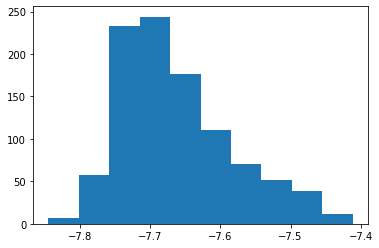

In [86]:
# Predictions on ER graphs
Y_pred_er = get_predictions(A_er, X_er)

plt.hist(Y_pred_er[:,2])

# Experiments

In [87]:
NUM_GRAPHS = 1000

In [88]:
def generate_graphs_from_params(n, m, alpha, num_graphs):
    """Generate num_graphs BA graphs with the given parameter values"""
    res = []
    for _ in range(num_graphs):
        res.append(barabasi_albert_graph(n,m,alpha))
    return res

def get_graphs(i, num_graphs, adj_test, y_pred):
    """Returns a graph representations of test graph with simulated graphs"""
    test_graph = adj_test[i]
    input_graph = nx.Graph(test_graph)
    params = y_pred[i,:]
    if NB_BARABASI_PARAM == 2:
        n,m = params
        alpha = 1
    elif NB_BARABASI_PARAM == 3:
        n,m,alpha = params
    if alpha <= 0: 
        alpha = 0.000000001
    output_graphs = generate_graphs_from_params(int(n), int(m), alpha, NUM_GRAPHS)
    return input_graph, output_graphs
    

def plot_scores(input_graphs, output_graphs, params, score_name="std_degree"):
    ncols = len(input_graphs)
    fig, axis = plt.subplots(1,ncols)
    
    scorer = GraphScorer()
    
    for idx,graph in enumerate(input_graphs):
        
        scores = [scorer.score(graph, score_name) for graph in output_graphs[idx]]
        input_score = scorer.score(graph, score_name)
        dist = sns.distplot(scores, ax=axis[idx],kde=False, norm_hist = True)#, color="dodgerblue", density = True)
        ymin, ymax = dist.get_ylim()
        axis[idx].vlines(input_score, ymin=ymin, ymax=ymax ,color="deeppink", label = "input")
        axis[idx].legend(loc = "upper right")
        if NB_BARABASI_PARAM == 2:
            textstr = '\n'.join((
                r'n=%.0f' % (int(params[idx][0]), ),
                r'm=%.0f' % (int(params[idx][1]), )))
        elif NB_BARABASI_PARAM == 3:
            textstr = '\n'.join((
                r'n=%.0f' % (int(params[idx][0]), ),
                r'm=%.0f' % (int(params[idx][1]), ),
                r'$\alpha=%.2f$' % (params[idx][2], )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axis[idx].text(0.05, 0.95, textstr, transform=axis[idx].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
    plt.suptitle("histogram for " + score_name)
    fig.set_figwidth(15)
    plt.show()

In [89]:
in_graphs, out_graphs, params = [],[],[]
# generate from three random test graphs
i1 = randint(0,Y_test.shape[0]-1)
i2 = randint(0,Y_test.shape[0]-1)
i3 = randint(0,Y_test.shape[0]-1)
for i in [i1,i2,i3]:
    cur_in, cur_out = get_graphs(i,NUM_GRAPHS,A_test,Y_pred)
    in_graphs.append(cur_in)
    out_graphs.append(cur_out)
    params.append(Y_test[i])

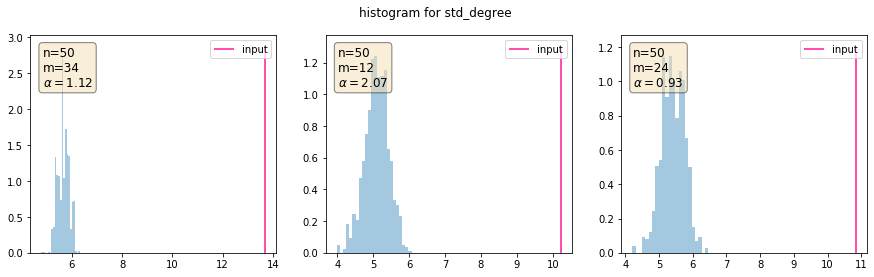

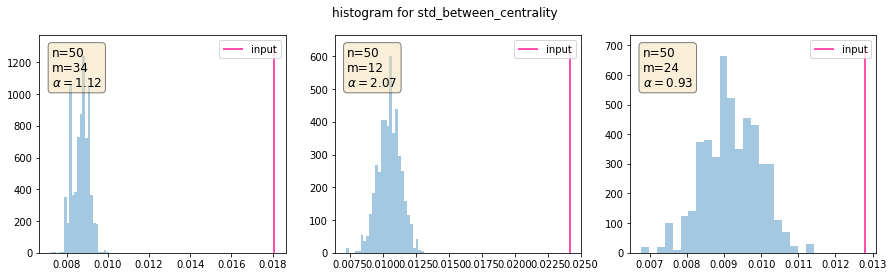

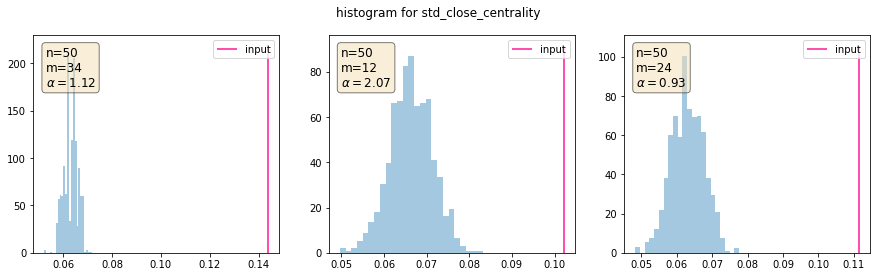

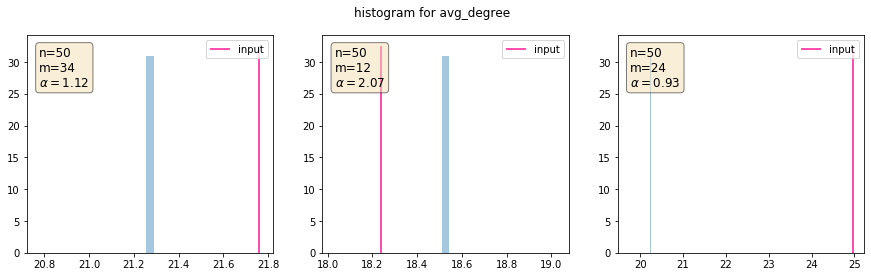

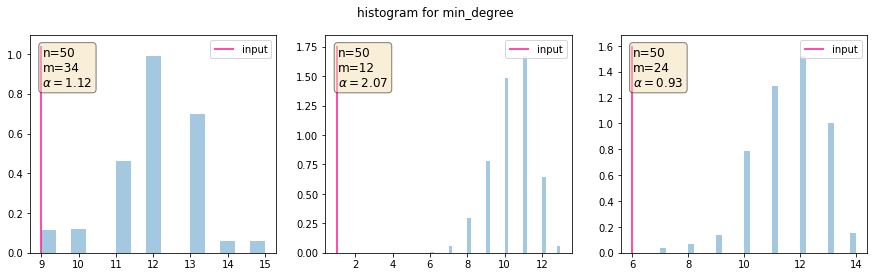

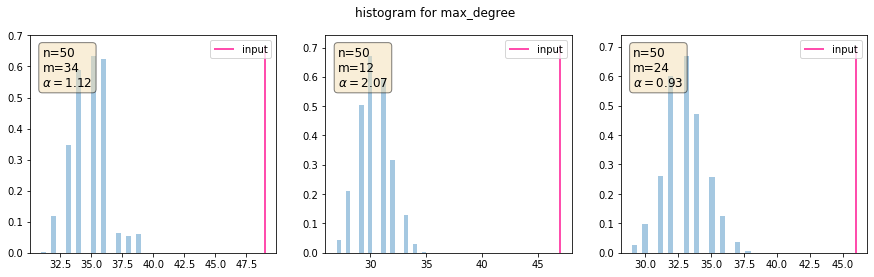

/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/andreasopedal/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


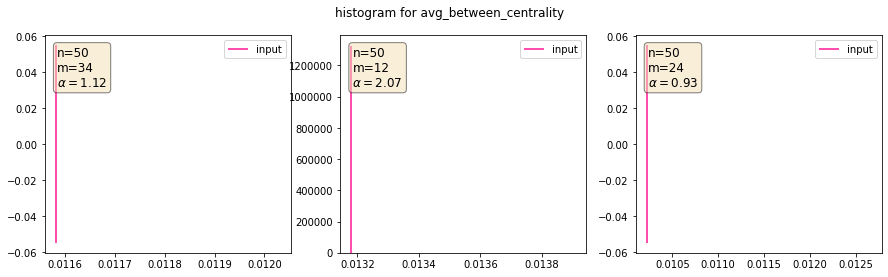

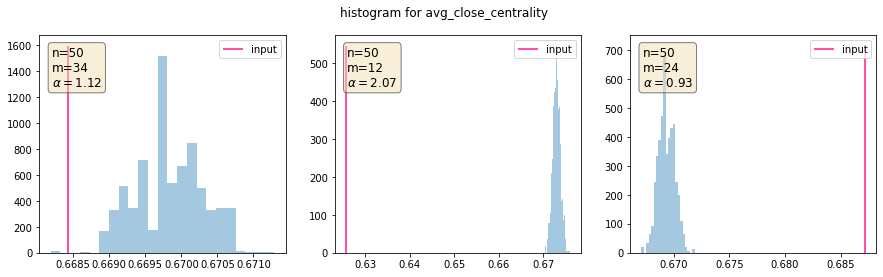

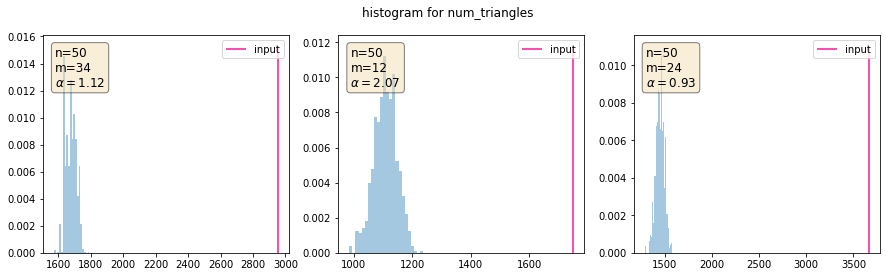

In [90]:
# Plot histograms

plot_scores(in_graphs, out_graphs, params)
plot_scores(in_graphs, out_graphs, params, "std_between_centrality")
plot_scores(in_graphs, out_graphs, params, "std_close_centrality")
plot_scores(in_graphs, out_graphs, params, "avg_degree")
plot_scores(in_graphs, out_graphs, params, "min_degree")
plot_scores(in_graphs, out_graphs, params, "max_degree")
plot_scores(in_graphs, out_graphs, params, "avg_between_centrality")
plot_scores(in_graphs, out_graphs, params, "avg_close_centrality")
plot_scores(in_graphs, out_graphs, params, "num_triangles")

## Plotting Barabasi-Albert graphs

In [91]:
def draw_random_ba_graphs(n, m, alpha, nrows=2, ncols=2,param='alpha',save=False):
 
    graphs = [barabasi_albert_graph(n, m, alpha) for idx in range(nrows * ncols)]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    ax = axes.flatten()
    for i in range(nrows * ncols):
        d = dict(graphs[i].degree)
        nx.draw_kamada_kawai(
            graphs[i],
            ax=ax[i],
            node_color="orchid",
            edge_color="grey",
            nodelist=d.keys(),
            node_size=[v**1.8  for v in d.values()],
            #node_color=range(n),
            cmap=plt.get_cmap('Greys')
        )
        #if param == 'alpha':
         #   ax[i].set_title(f'{param}={np.round(alpha,decimals=2)}')
        #elif param == 'm':
         #   ax[i].set_title(f'{param}={m}')
        #ax[i].set_axis_off()
    if param == 'alpha':
        fig.suptitle(f"{param}={np.round(alpha,decimals=2)}")
    elif param == 'm':
         fig.suptitle(f"{param}={np.round(m,decimals=2)}")
    
    if save:
        plt.savefig(f"BA_n_{n}_m_{m}_alpha_{alpha}.png")
    plt.show()

In [92]:
def draw_ba_graphs_alphas(n, m, alphas, nrows=1, ncols=3,param='alpha',save=False):
 
    graphs = [barabasi_albert_graph(n, m, alphas[i]) for i in range(len(alphas))]
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,3))
    ax = axes.flatten()
    for i in range(len(alphas)):
        d = dict(graphs[i].degree)
        nx.draw_kamada_kawai(
            graphs[i],
            ax=ax[i],
            node_color="orchid",
            edge_color="grey",
            nodelist=d.keys(),
            node_size=[v**1.8  for v in d.values()],
            #node_color=range(n),
            cmap=plt.get_cmap('Greys')
        )
        ax[i].set_title(r'$\alpha=$'+f'{np.round(alphas[i],decimals=2)}')
       
        #ax[i].set_axis_off()
   
    if save:
        plt.savefig(f"BA_n_{n}_m_{m}_alphas_{alphas}.png")
    plt.show()
    

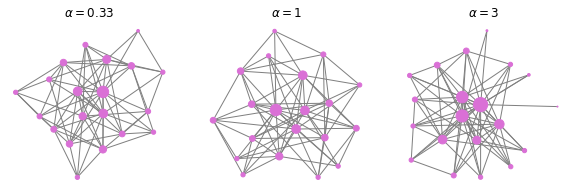

In [93]:
alphas=[1/3,1,3]
draw_ba_graphs_alphas(n=20,m=5,alphas=alphas,ncols=3,param='alpha',save=False)